# Thomas Hill, Summer 2020
# DATA 604 Final Project:
## Simulation of vancomycin dosing regimen using a one-compartment model
### Introduction

Vancomycin is an essential antibiotic for the management of serious infections. It is a common adjuvant to broad spectrum or empiric antimicrobial therapy, and has excellent Gram positive bacterial coverage,including methicillin-resistant Staphylococcus aureus (MRSA). Typically, vancomycin and other antibiotics will be started as soon as an initial microbiology sample is collected, and once bacterial culture and susceptibilities are identified a more specific drug can be selected for the infection.

A common feature of vancomycin therapy is monitoring of drug concentrations, owing to the drug’s narrow therapeutic index. Like many antibiotics, vancomycin must achieve an adequate tissue concentration toinhibit and kill bacteria. However, high vancomycin levels are associated with nephrotoxicity and reversible kidney injury, as well as ototoxicity and worsening of existing hearing impairment. Vancomycin blood concentrations are taken 30 minutes prior to the next dose for a trough level, and dose and sometimes frequency of administration are adjusted.

### Modeling Approach/ Justification

Vancomycin is a straightforward medication to model, as its therapeutic and toxic concentrations are well defined, it diffuses predictably into most body tissues from the bloodstream, and clearance from the body is as unchanged drug via glomerular filtration in the kidneys. For this model I will simulate recurrent intermittent infusions overlying first-order elimination. Similar to the SIRS model studied in class, pharmacokinecis often use a 'compartment' scheme of modeling. Depending on the route of administration and site of action, drugs may be modeled by a 1-, 2-, or 3-compartment model. Vancomycin is ideally mondeled during a two-compartment model as this ensures considerations for protein binding in the bloodstream and dissipation throughout the whole body, but for my purposes I am primarily interested in measurable concentrations in the bloodstream. 

A one-compartment model is primarily dependent on the current drug concentration and the elimination constant ke (min**-1), which is the ratio of drug clearance (mL/min) to apparent volume of distribution (L) within the body. I will derive these latter two from randomly generated patient demographics to obtain a personal ke.  Additionally, I will base vancomycin dosing on generally accepted standards of therapy. 

### Goals
 
The purpose of the simulation is to explore practical issues related to vancomycin dosing, and validate the common dosing conventions and standard procedures are valid for the majority of patients. Primarily, I am interested in the most common  regimen in patients with stable renal function: three doses given equal intervals apart, then an initial trough concentration taken prior to the fourth dose.  The fourth dose is significant as this is expected to be the earliest that vancomycin is at steady state, or reaching a stable dose-to-dose concentration. To measure the success, I will look at the final trough concentration at 72 hours and see if it therapeutic. Additionally, I will look at the trough prior to 4th dose and see if it also is therapeutic, and potentially model a dose change if the trough level isn't within the target range. 
 

Using SimPy, write a process simulation that includes waiting time (discrete event simulation).  You may use any topic of interest to you.  Write the simulation and all of the following in Jupyter.

Each element is worth 5 points and will be graded using the rubric shown here.

1.  State the problem and its significance.

2.  Provide a flow-chart model. 

3.  Simulate the process for the appropriate number of iterations (justify)

4.  Justify the validity of the model and discuss how you verified it.

5.  State  your conclusions/ findings from the model. 

6.  Generate appropriate graphs (more than one) to illustrate the results and provide a PowerPoint presentation to share with your colleagues.  Post this to the discussion. 

Be sure that your code works!


### Flow Chart

### Simulation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from modsim import *
from math import floor

# set the random number generator
np.random.seed(11206)

In [2]:
#define three functions to better assign values based on patient characteristics

def get_age(turn, end, size): #I Googled 'trapezoidal distribution' to better model age
    pass
    totarea = turn + (end-turn)/2  # rectangle + triangle
    areauptoturn = turn             # rectangle
    areasloped = (end-turn)/2     # triangle
    size1= int(size*areauptoturn/totarea)
    size2= size- size1 
    s1 = np.random.uniform(low=0,high=turn,size= size1)  # (low=0.0, high=1.0, size=None)
    s2 = np.random.triangular(left=turn,mode=turn,right=end,size=size2) #(left, mode, right, size=None)
            # mode : scalar-  the value where the peak of the distribution occurs. 
            #The value should fulfill the condition left <= mode <= right.
    s3= np.concatenate((s1,s2)) # don't use add , it will add the numbers piecewise
    return s3


age_dist = 20 + get_age(40,60, 4000)

def get_weight(gender):
    if gender == 0:
        np.random.normal(77.3,12)
    else:
        np.random.normal(89.7,12)

        
def CrCl_wt(weight): #the Crockoft-Gault equation works best when it does not overestimate body weight > 72kg
    if weight <= 72:
        return weight
    else:
        return 72
    

def get_CrCl(params): #the Crockoft-Gault equation works best when it does not overestimate body weight > 72kg
    CrCl = (140 - params.age) * (CrCl_wt(params.weight))/(72 * params.scr)
    if params.gender == 0:
         return 0.85 * CrCl
    else:
        return CrCl

    
def get_tau(params): #dosing frequency is based on stepwise cutoffs of renal function
    if get_CrCl(params) < 40:
        return 24
    elif get_CrCl(params) > 60:
        return 8
    else:
        return 12
            #If CrCl >60ml/min then q8h; if CrCl 40 - 60ml/min, then q12h; if CrCl <40, then q24h

In [12]:
#define inital parameter of concentration where initial concentration is zero

def get_patient():
    gender = np.random.randint(0,2)
    age = int(np.random.choice(age_dist))
    scr = np.random.uniform(0.6,1.2)
    params = Params(gender = gender, age = age, 
                    weight = np.random.normal(77.3+(89.7-77.3)*gender, 12),  #normally distributed, dependent on gender
                    height = np.random.normal(1.615+(1.753-1.615)*gender, 0.0711+(0.0742-0.0711)*gender), #normally distributed, dependent on gender
                 scr = scr
                   )

    return params 


def get_vanco_dosing(params):
    
    V = np.random.uniform(0.7,0.9)*params.weight, #volume of drug distribution, liters
    CL = 3.66 + 0.06 * (0.689 * get_CrCl(params)),
    wt = params.weight
    Dose = 250*round(17.5 * params.weight/250, 0), #rounds dose to the nearest 250mg
    T_infuse = float(0.5*round(250*round(17.5 * params.weight/250, 0)/500, 0)), #infuse 500mg over 30 minutes, or 1/2 hour
    Tau = get_tau(params) #dosing frequency in hours, based on renal function CrCl 
    
    return Params(C_0 = 0, CL = CL[0], V = V[0], Dose = Dose[0], T_infuse = T_infuse[0], Tau = Tau)
'''if loading dose is wanted, let C_0 = 25*params.weight/V[0]'''

'if loading dose is wanted, let C_0 = 25*params.weight/V[0]'

In [4]:
#below is some code I used to verify that my parameters were generating suitable distributions of numbers

'''test_param = []
for i in range(4000):
    age = int(np.random.choice(age_dist)) #randomly select age between 20 and 79 years
    gender = np.random.randint(0,2) #0 for female, 1 for male
    height = np.random.normal(1.615+(1.753-1.615)*gender, 0.0711+(0.0742-0.0711)*gender)
    weight = np.random.normal(77.3+(89.7-77.3)*gender, 12)  #normally distributed, dependent on gender
    scr = np.random.uniform(0.6,1.2) #uniform distribution of renal function
    CrCl = (0.85+0.15*gender)*(140-age)*(CrCl_wt(weight))/(72 * scr) #Crockoft-Gault formula for renal function, mL/min
    V = np.random.uniform(0.7,0.9)*weight #volume of drug distribution, liters
    CL = 3.66 + 0.06 * (0.689 * CrCl)
    k = CL/V
    Tau =  get_tau(CrCl)
    test_param.append(Tau)

test_param = np.asarray(test_param)    
plt.hist(test_param)'''

'test_param = []\nfor i in range(4000):\n    age = int(np.random.choice(age_dist)) #randomly select age between 20 and 79 years\n    gender = np.random.randint(0,2) #0 for female, 1 for male\n    height = np.random.normal(1.615+(1.753-1.615)*gender, 0.0711+(0.0742-0.0711)*gender)\n    weight = np.random.normal(77.3+(89.7-77.3)*gender, 12)  #normally distributed, dependent on gender\n    scr = np.random.uniform(0.6,1.2) #uniform distribution of renal function\n    CrCl = (0.85+0.15*gender)*(140-age)*(CrCl_wt(weight))/(72 * scr) #Crockoft-Gault formula for renal function, mL/min\n    V = np.random.uniform(0.7,0.9)*weight #volume of drug distribution, liters\n    CL = 3.66 + 0.06 * (0.689 * CrCl)\n    k = CL/V\n    Tau =  get_tau(CrCl)\n    test_param.append(Tau)\n\ntest_param = np.asarray(test_param)    \nplt.hist(test_param)'

In [13]:
#define system to model vanco dose over time

def make_system(params):
    
    
    """Makes a System object with the given parameters.
    params: sequence of C_0, CL, V, Dose, T_infuse, Tau
    
    C_0 = initial concentration, 
    V = apparent volume of distribution, L
    CL = drug clearance, L/hr
    Dose = recommended vancomycin dose, mg
    T_infuse = infusion rate based on vanco dose, hours
    Tau = frequency of dosing interval
    
    returns: System object
    """
    C_0, CL, V, Dose, T_infuse, Tau = params
    
    t_0 = 0
    t_end = 72
    
    init = State(Conc = C_0)

    return System(params, init = init, t_0 = t_0, t_end = t_end, dt = 0.5)

In [6]:
#create dosing function for simulation of intravenous infusion

# infusion function
def infusion(system, t):
    if t % system.Tau < system.T_infuse: #this checks whether a repeat dose is due 
        return system.Dose/system.T_infuse #intermittent dose administration
    else:
        return 0 #dose is 0 when between doses

#create update function for system
def update_func(state, t, system):
    """Updates the vancomycin one-compartment model.
    
    state: State object
    t: time in hours
    system: System object
    
    returns: State object
    """
    Conc = state
    V, CL, T_infuse, Tau, dt = system.V, system.CL, system.T_infuse, system.Tau, system.dt 
        
    dcdt =  infusion(system, t) /V - (CL/V)*Conc
    
    Conc += dcdt * dt

    return State(Conc = Conc)

In [7]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

In [14]:
params = get_patient()
test_vanco = get_vanco_dosing(params)
test_system = make_system(test_vanco)
test_results = run_simulation(test_system, update_func)

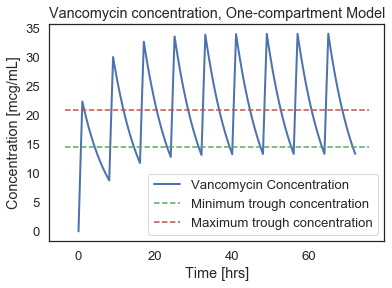

In [15]:

def plot_concentration(results):
    plot(results.Conc)
    plt.plot(plt.xlim(),[14.5,14.5],'g--',plt.xlim(),[21,21],'r--')
    plt.legend(['Vancomycin Concentration','Minimum trough concentration','Maximum trough concentration'])
    plt.xlabel('Time [hrs]')
    plt.ylabel('Concentration [mcg/mL]')
    plt.title('Vancomycin concentration, One-compartment Model');

plot_concentration(test_results)

### Model Validation

The most appropriate model validation I chose to use was to see whether the concentrations predicted by my model fell within an acceptable range of values. This dosing regimen should generate trough concentrations between 15 and 20 micgrograms/milliliter

### Conclusions and future directions

### Sources and further reading

Inspiration for simulating vancomycin pharmacokinetics: a Github repository for vancomycin Shiny app. This is based on a two-compartment model  https://github.com/asancpt/shiny-vtdm

Code basis for one-compartment pharmacokinetics: https://jckantor.github.io/CBE30338/03.05-One-Compartment-Pharmacokinetics.html

